### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 30th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
  What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try   
   `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to 
   inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

# SOLUTIONS

### Problem 1 

#### 1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.

In [226]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats


# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw7_data_1.npy') 

# Extract data (500 samples)
X1 = data[:, 0] #first column is feature 1
X2 = data[:, 1] #Second column is feature 2
Y = data[:,2] # Target labels 
yerr = data[:,3] #Third column is y heteroscedastic uncertainties

print, len(X1), len(Y), len(yerr)

(<function print>, 500, 500, 500)

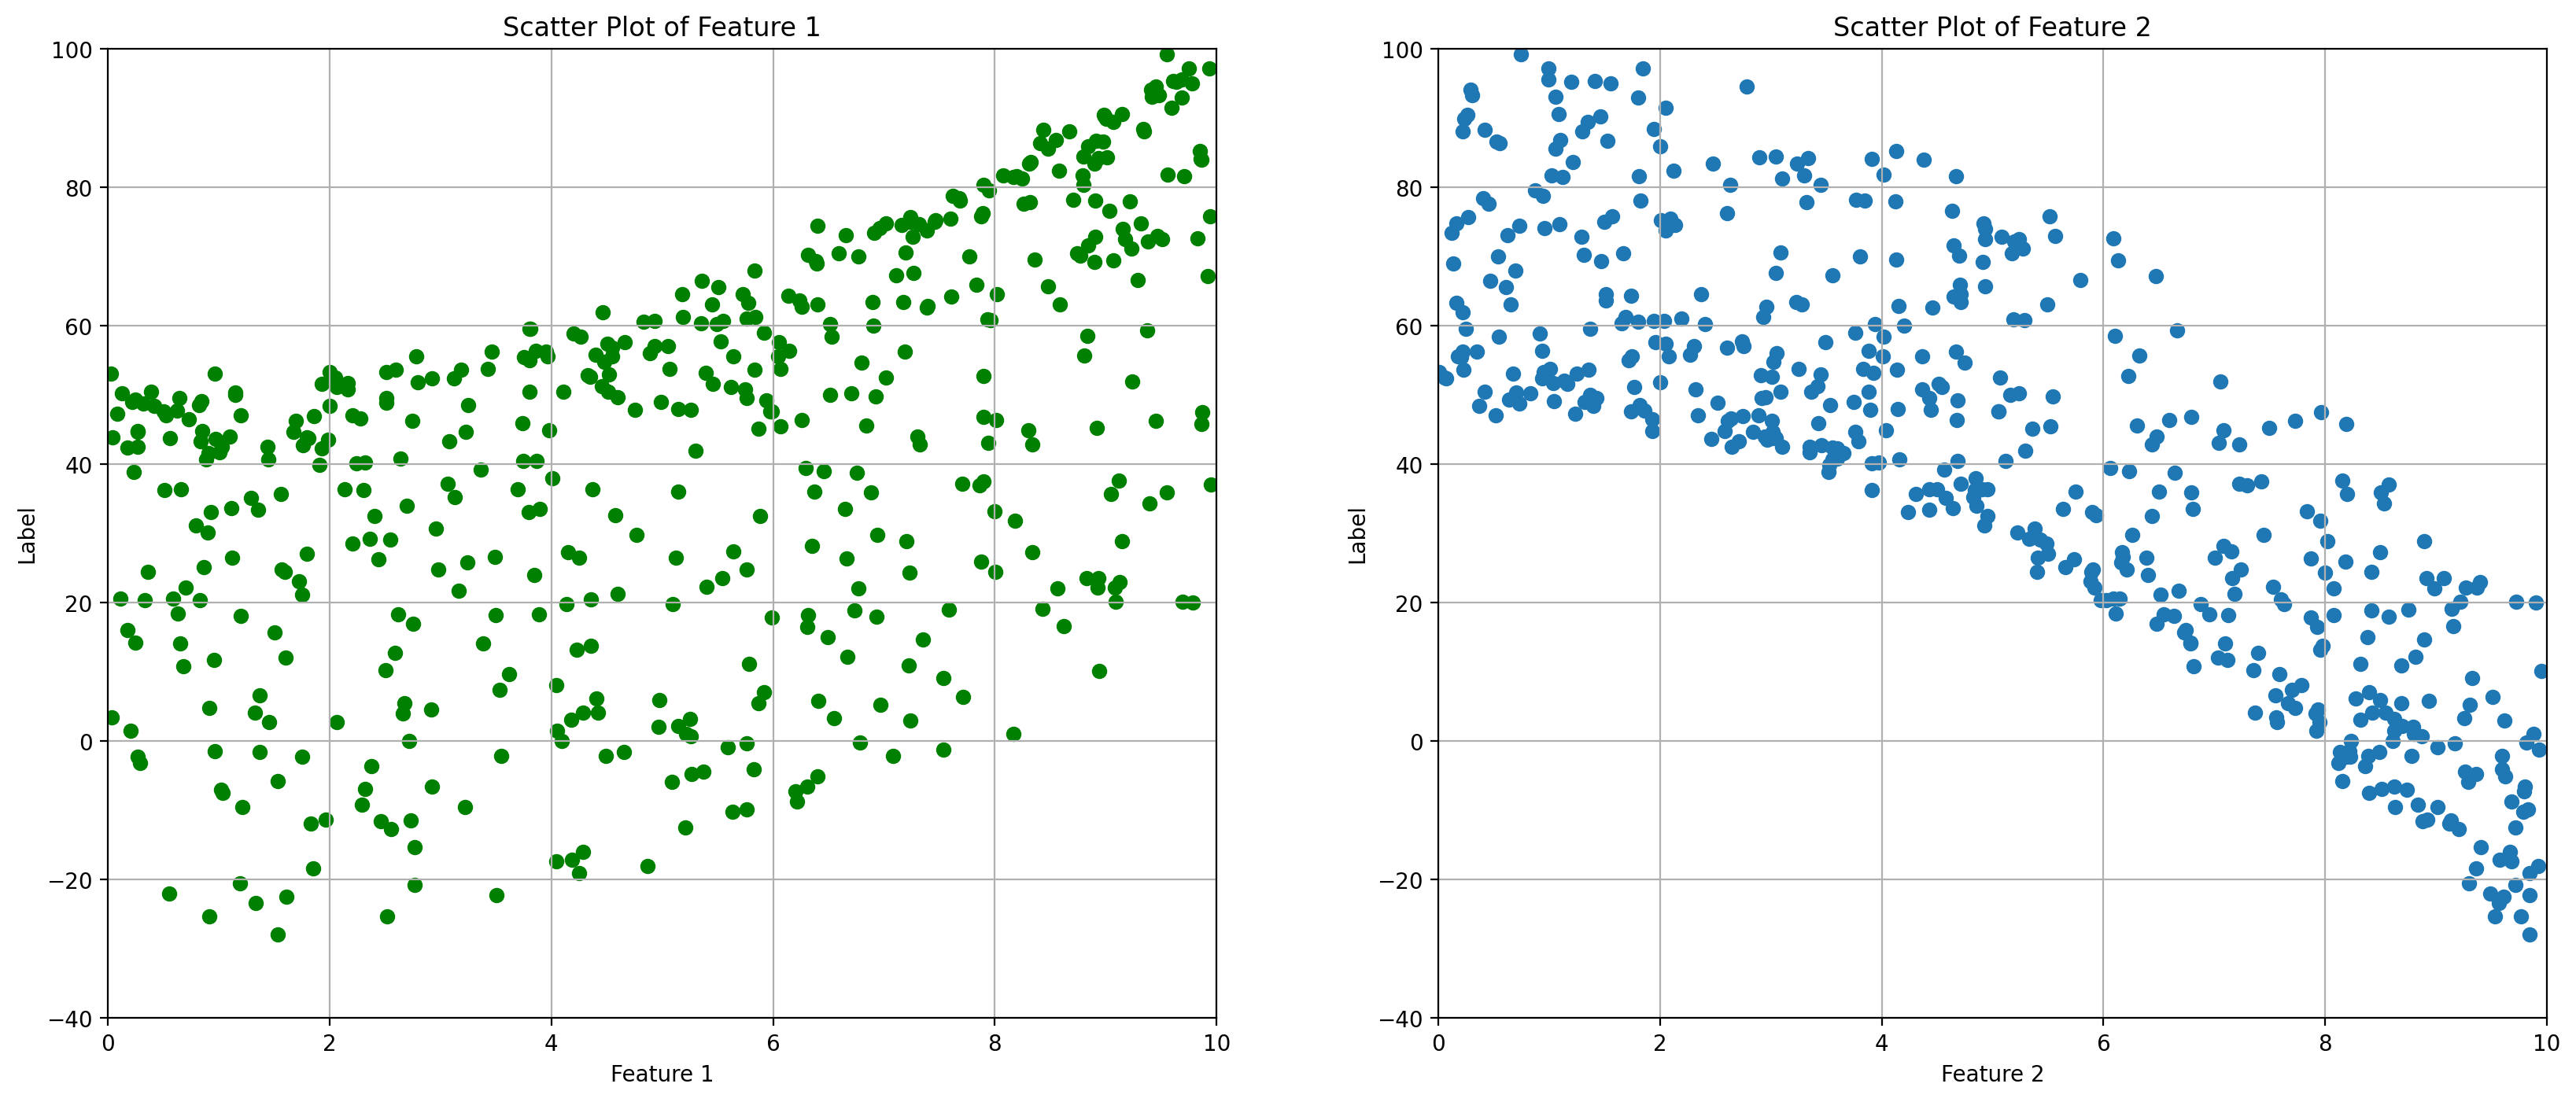

In [227]:
# Plot the data of the two features as a panel 
plt.figure(figsize=(20, 8))

#Feature 1
plt.subplot(1, 2, 1)  
scatter1 = plt.scatter(X1, Y, color='g')
plt.title('Scatter Plot of Feature 1')
plt.xlabel('Feature 1')
plt.ylabel('Label')
plt.ylim(-40,100)
plt.xlim(0,10)
plt.grid(True)


#Feature 2
plt.subplot(1, 2, 2) 
scatter2 = plt.scatter(X2, Y)
plt.title('Scatter Plot of Feature 2')
plt.xlabel('Feature 2')
plt.ylabel('Label')
plt.ylim(-40,100)
plt.xlim(0,10)
plt.grid(True)


plt.show()

## Problem 2 


#### 2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?

In [228]:
from astroML.linear_model import LinearRegression

#Combine X1 and X2 
X = np.vstack((X1, X2)).T

# Fit model
model = LinearRegression()
model.fit(X, Y, yerr)

print("Intercept:", model.coef_[0])
print("Slopes", model.coef_[1:])

Intercept: 57.101023232995516
Slopes [ 4.94873016 -8.30023407]


SRT: Nice

In [229]:
#Predict values and plot best fit
X1_grid = np.linspace(X1.min(), X1.max(), 50)
X2_grid = np.linspace(X2.min(), X2.max(), 50)


X1_mean = np.mean(X1)
X2_mean = np.mean(X2)
X_pred1 = np.vstack((X1_grid, np.full_like(X1_grid, X2_mean))).T 
X_pred2 = np.vstack((np.full_like(X2_grid, X1_mean), X2_grid)).T 

# Predictions
y_pred1 = model.predict(X_pred1)
y_pred2 = model.predict(X_pred2)

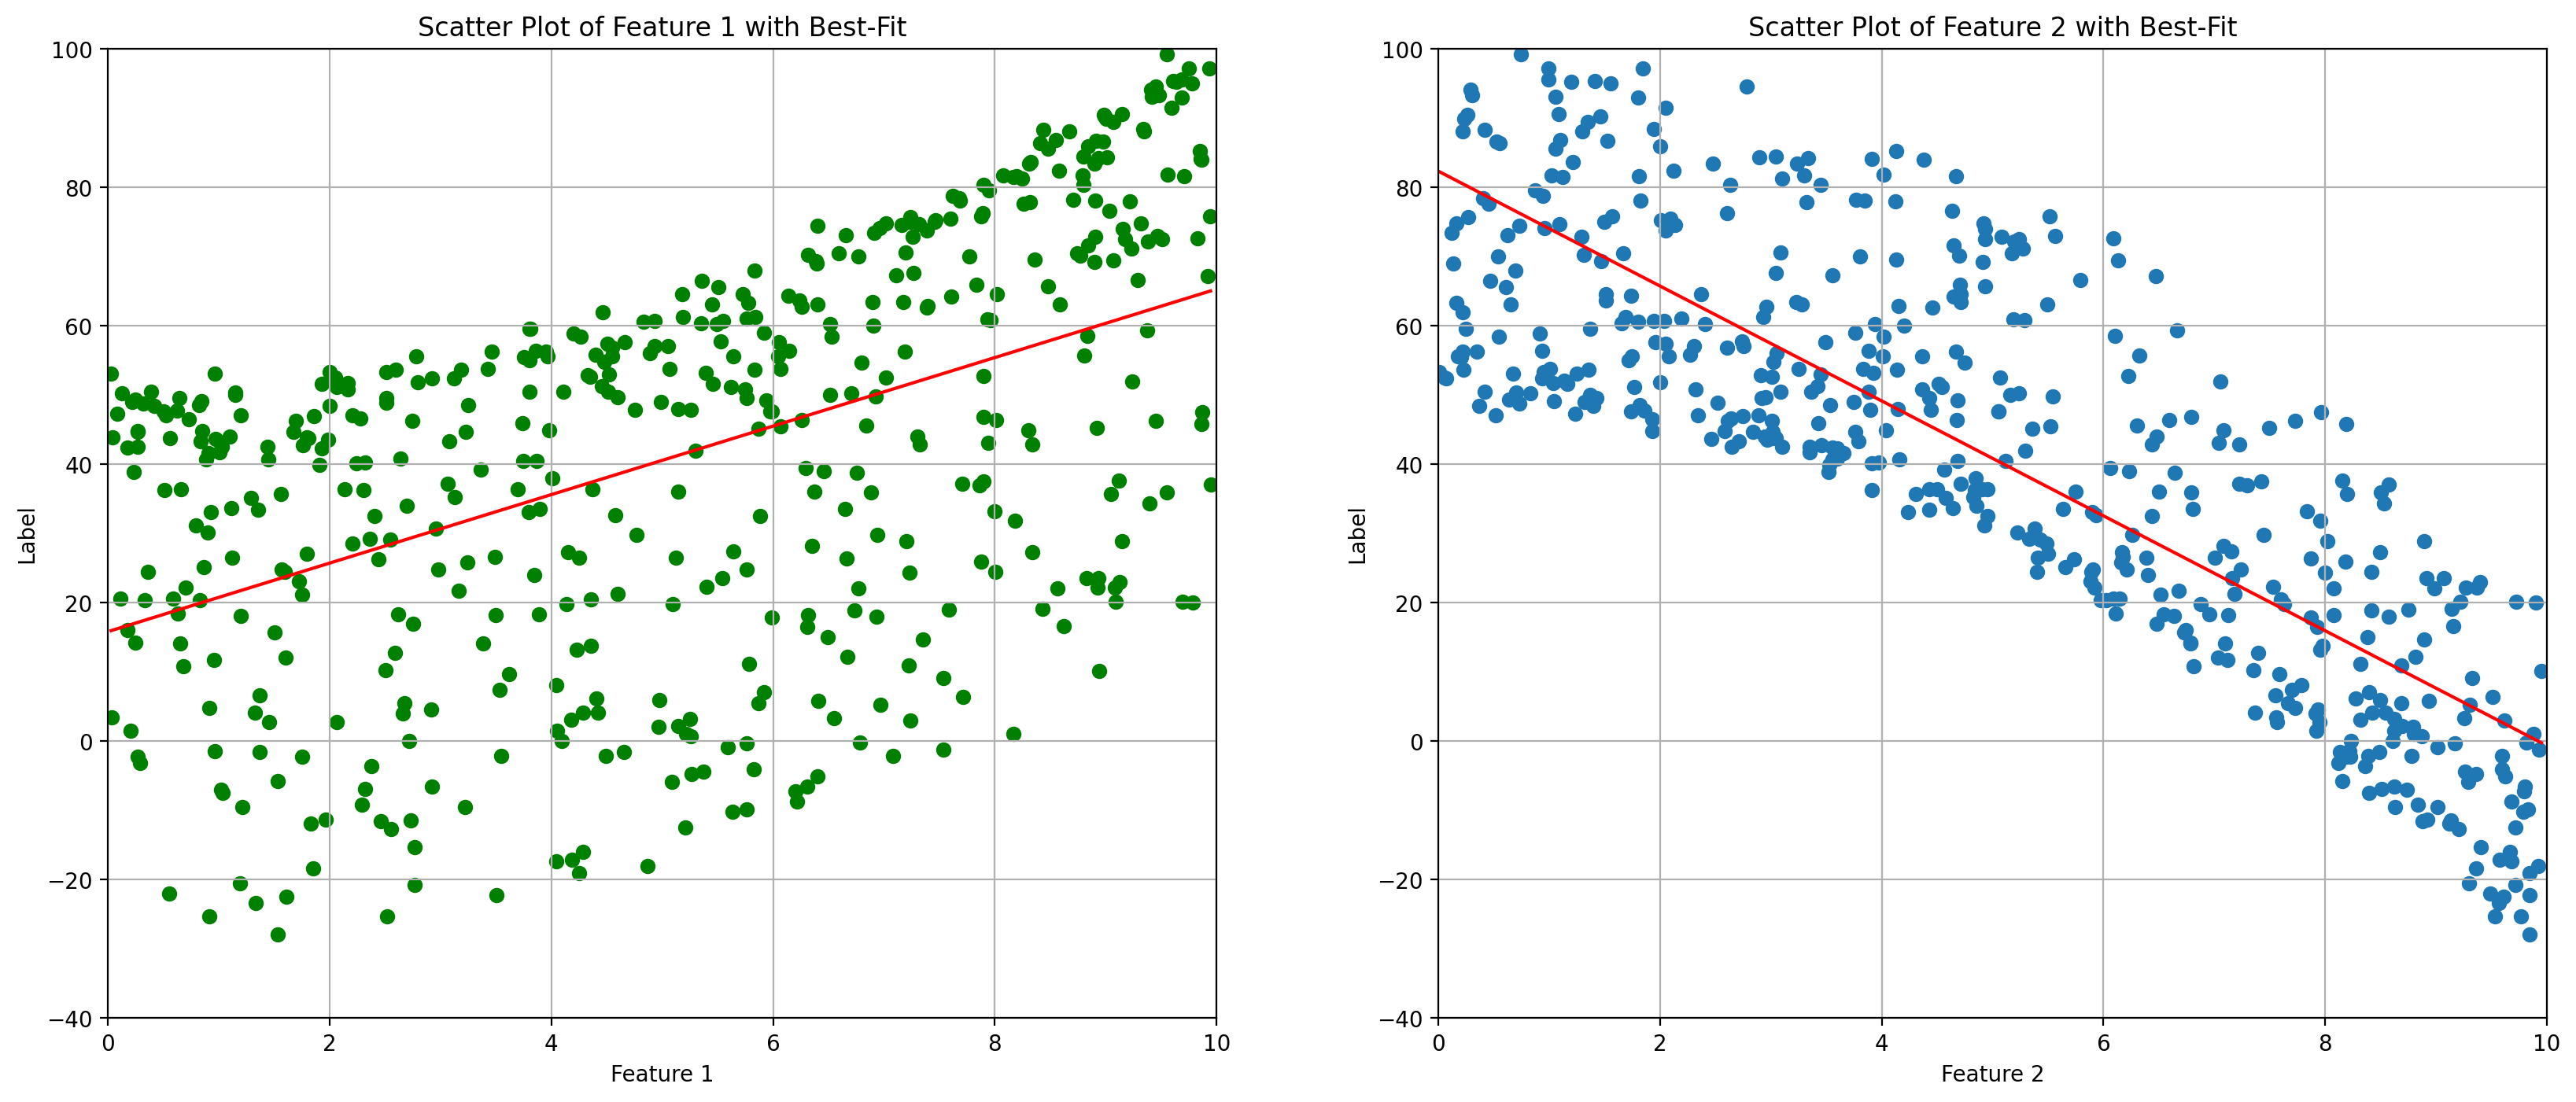

In [230]:
plt.figure(figsize=(20, 8))

# Plot for Feature 1
plt.subplot(1, 2, 1)
plt.scatter(X1, Y, color='green') # data
plt.plot(X1_grid, y_pred1, color='red') #best fit line
plt.title('Scatter Plot of Feature 1 with Best-Fit')
plt.xlabel('Feature 1')
plt.ylabel('Label')
plt.xlim(0,10)
plt.ylim(-40,100)
plt.grid(True)

# Plot for Feature 2
plt.subplot(1, 2, 2)
plt.scatter(X2, Y)
plt.plot(X2_grid, y_pred2, color='red')  
plt.title('Scatter Plot of Feature 2 with Best-Fit')
plt.xlabel('Feature 2')
plt.ylabel('Label')
plt.xlim(0,10)
plt.ylim(-40,100)
plt.grid(True)

plt.show()

#### Response to problem 2: In my opinion, the best fit line on the data is not terrible. I can see that with both features, there are more points clustered on the edges. For example with feature 1, there is more data where the label values are high, i.e. around 40 to 100, and with feature 2 the data is more densley clustered from labels -40 and 40. Both of these would drag the line of best fit towards the regions with more data points. However, it is possible other lines of best fit would do the data more justice. 

## Problem 3


#### 3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.


In [231]:
# install the relevant interactive plot packages
# only do this once
#!pip install ipywidgets ipympl;

In [247]:
#Make 2d meshgrid
X1_grid, X2_grid = np.meshgrid(np.linspace(X1.min(), X1.max(), 50), np.linspace(X2.min(), X2.max(), 50))

# Flatten
X_grid_flat = np.vstack([X1_grid.ravel(), X2_grid.ravel()]).T

# Predict
Y_grid_pred = model.predict(X_grid_flat).reshape(X1_grid.shape)

<span style="color:darkred">



#### I was running into java script issues while trying to use the notebook widget. I tried updating my jupyter lab and also switching back to matplotlib notebooks as a workaround because it would not recognize MPLCanvasModel, however the notebook said this was not allowed. I have switched back to the non-interactive static plot just to show the results

<span/>

SRT: Good, thanks for noting this, Shaniya.

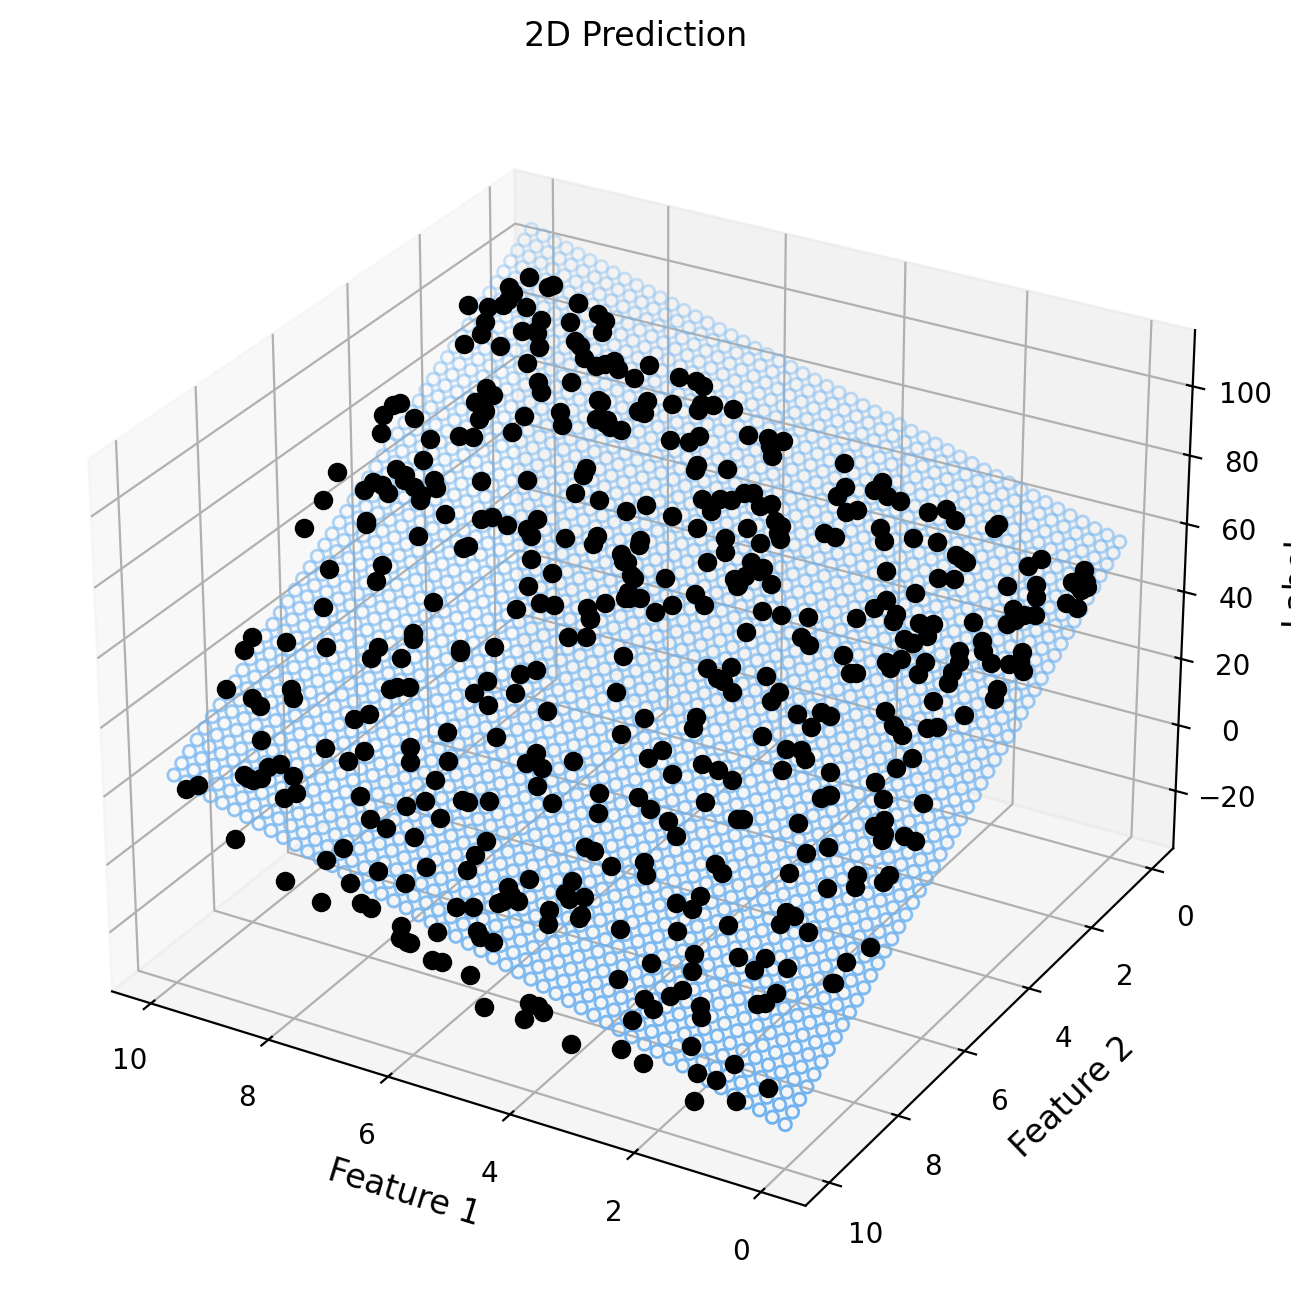

In [233]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Data
ax.plot(X1, X2, Y, color='k', zorder=15, linestyle='none', marker='o')
ax.scatter(X1_grid.flatten(), X2_grid.flatten(), Y_grid_pred.flatten(),
           facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

#Labels
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_zlabel('Label', fontsize=12)
ax.set_title('2D Prediction')

ax.view_init(elev=28, azim=120)

plt.show()


## Problem 4

#### 4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# Parameter for ridge
ridge_params = {'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}

K = 5  
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=K)
ridge_grid.fit(X, Y)

# Find top values
top_params = ridge_grid.best_params_  
top_score = ridge_grid.best_score_

print("The top parameter for Ridge regression is:", top_params)
print("The top score for Ridge regression is:", top_score)

The top parameter for Ridge regression is: {'alpha': 1.0, 'solver': 'svd'}
The top score for Ridge regression is: 0.9290800590702192


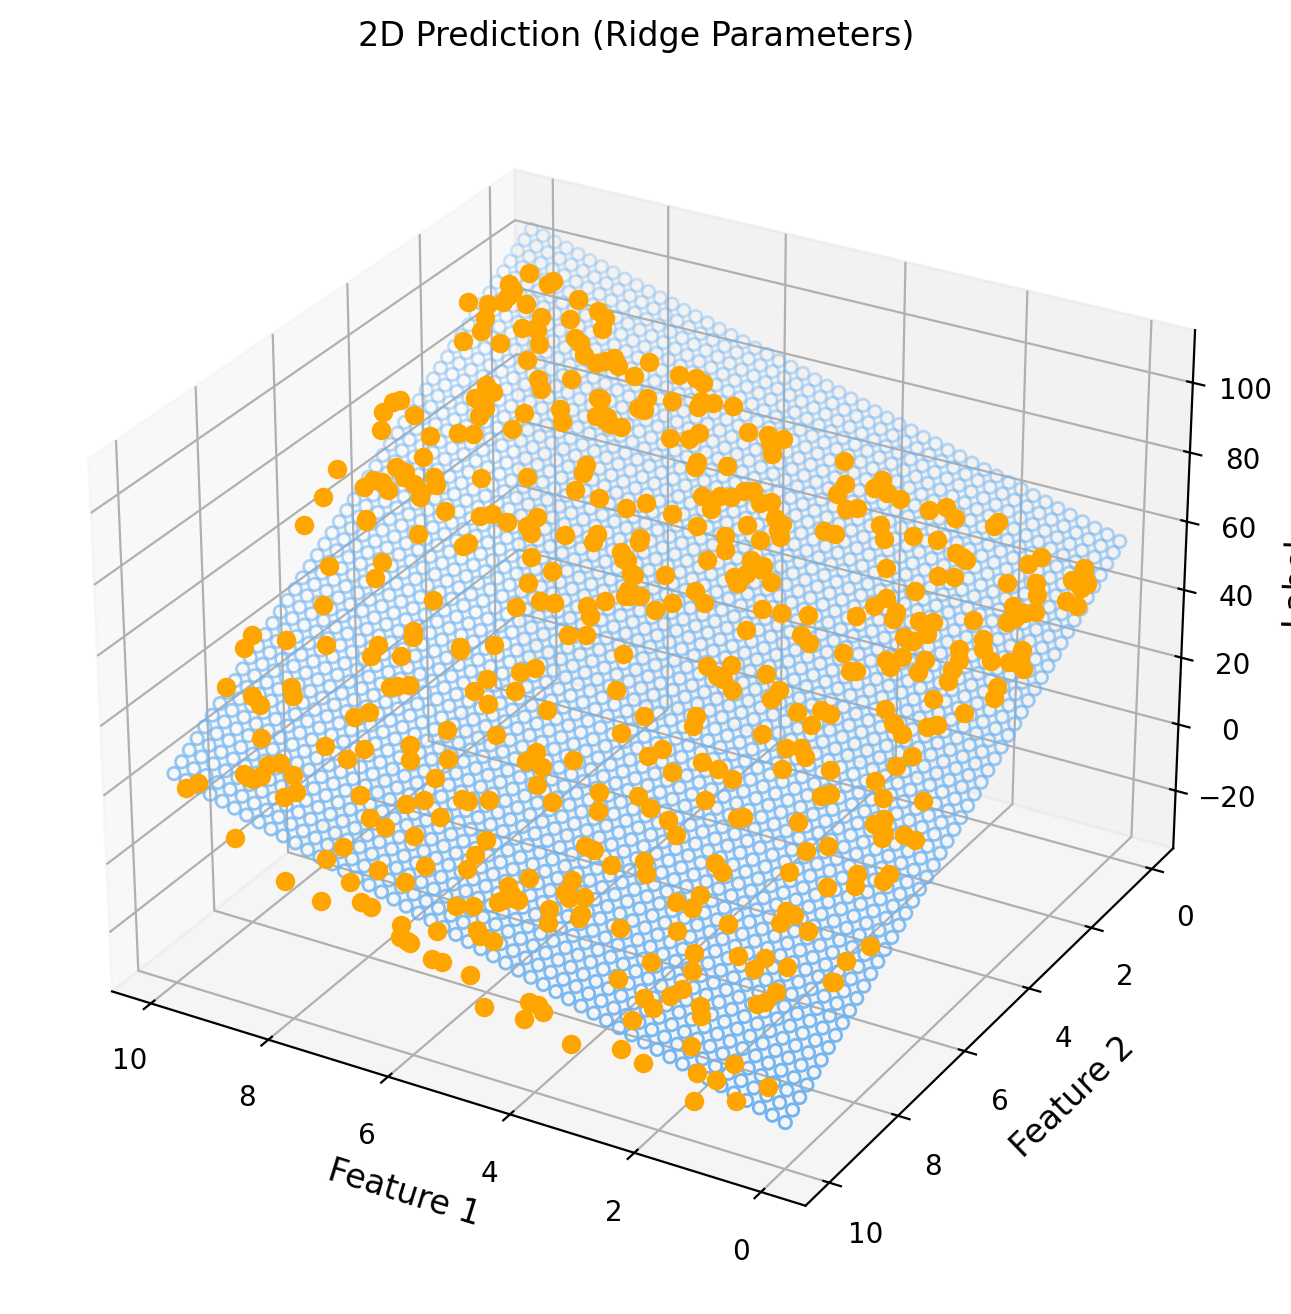

In [235]:
#Use Ridge Parameters
ridge_best = Ridge(**top_params) #Adding ** is used when you want to get into the value of a dictionary 
ridge_best.fit(X, Y)
Y_grid_predRidge = ridge_best.predict(X_grid_flat).reshape(X1_grid.shape)


# Plot Data
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X1, X2, Y, color='orange', zorder=15, linestyle='none', marker='o')
ax.scatter(X1_grid.flatten(), X2_grid.flatten(), Y_grid_predRidge.flatten(),
           facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

#Labels
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_zlabel('Label', fontsize=12)
ax.set_title('2D Prediction (Ridge Parameters)')


ax.view_init(elev=28, azim=120)
plt.show()

In [236]:
#Use RidgeCV
alphas = np.array([0.05, 0.1, 0.2, 0.5, 1.0])
ridge_cv = RidgeCV(alphas=alphas, cv=K, scoring='neg_mean_squared_error')
ridge_cv.fit(X, Y)

#Top value
alpha_ridgecv = ridge_cv.alpha_
print("Best alpha from RidgeCV is:", alpha_ridgecv)

Best alpha from RidgeCV is: 1.0


#### Yes the value from the GridSearchCV and the RidgeCV agree, as the first was about 0.92 and the second value was 1. This means that each method agrees the best value falls within that range, and that our best alpha selection is reliable. Using these values will prevent us from overfitting to the data due to the penalty of having large coefficients. However, if the alpha value was larger this would mean we have a more simple model, but then it might not catch all of the details of the data. 

## Problem 5

#### 5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


In [237]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.gaussian_process.kernels import RBF   #, ConstantKernel as C

# No uncertainties
kernel = kernels.RBF(0.5, (0.01, 100.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
Fit = gp.fit(X, Y)

# With uncertainties
alpha = (yerr / Y) ** 2
gp_uncertainty = GaussianProcessRegressor(kernel=kernel, alpha=alpha.flatten(), n_restarts_optimizer=20)
Fit_uncertainty = gp_uncertainty.fit(X, Y)

In [238]:
Y_grid_pred = gp.predict(X_grid_flat).reshape(X1_grid.shape)
Y_grid_pred_uncertainty = gp_uncertainty.predict(X_grid_flat).reshape(X1_grid.shape)

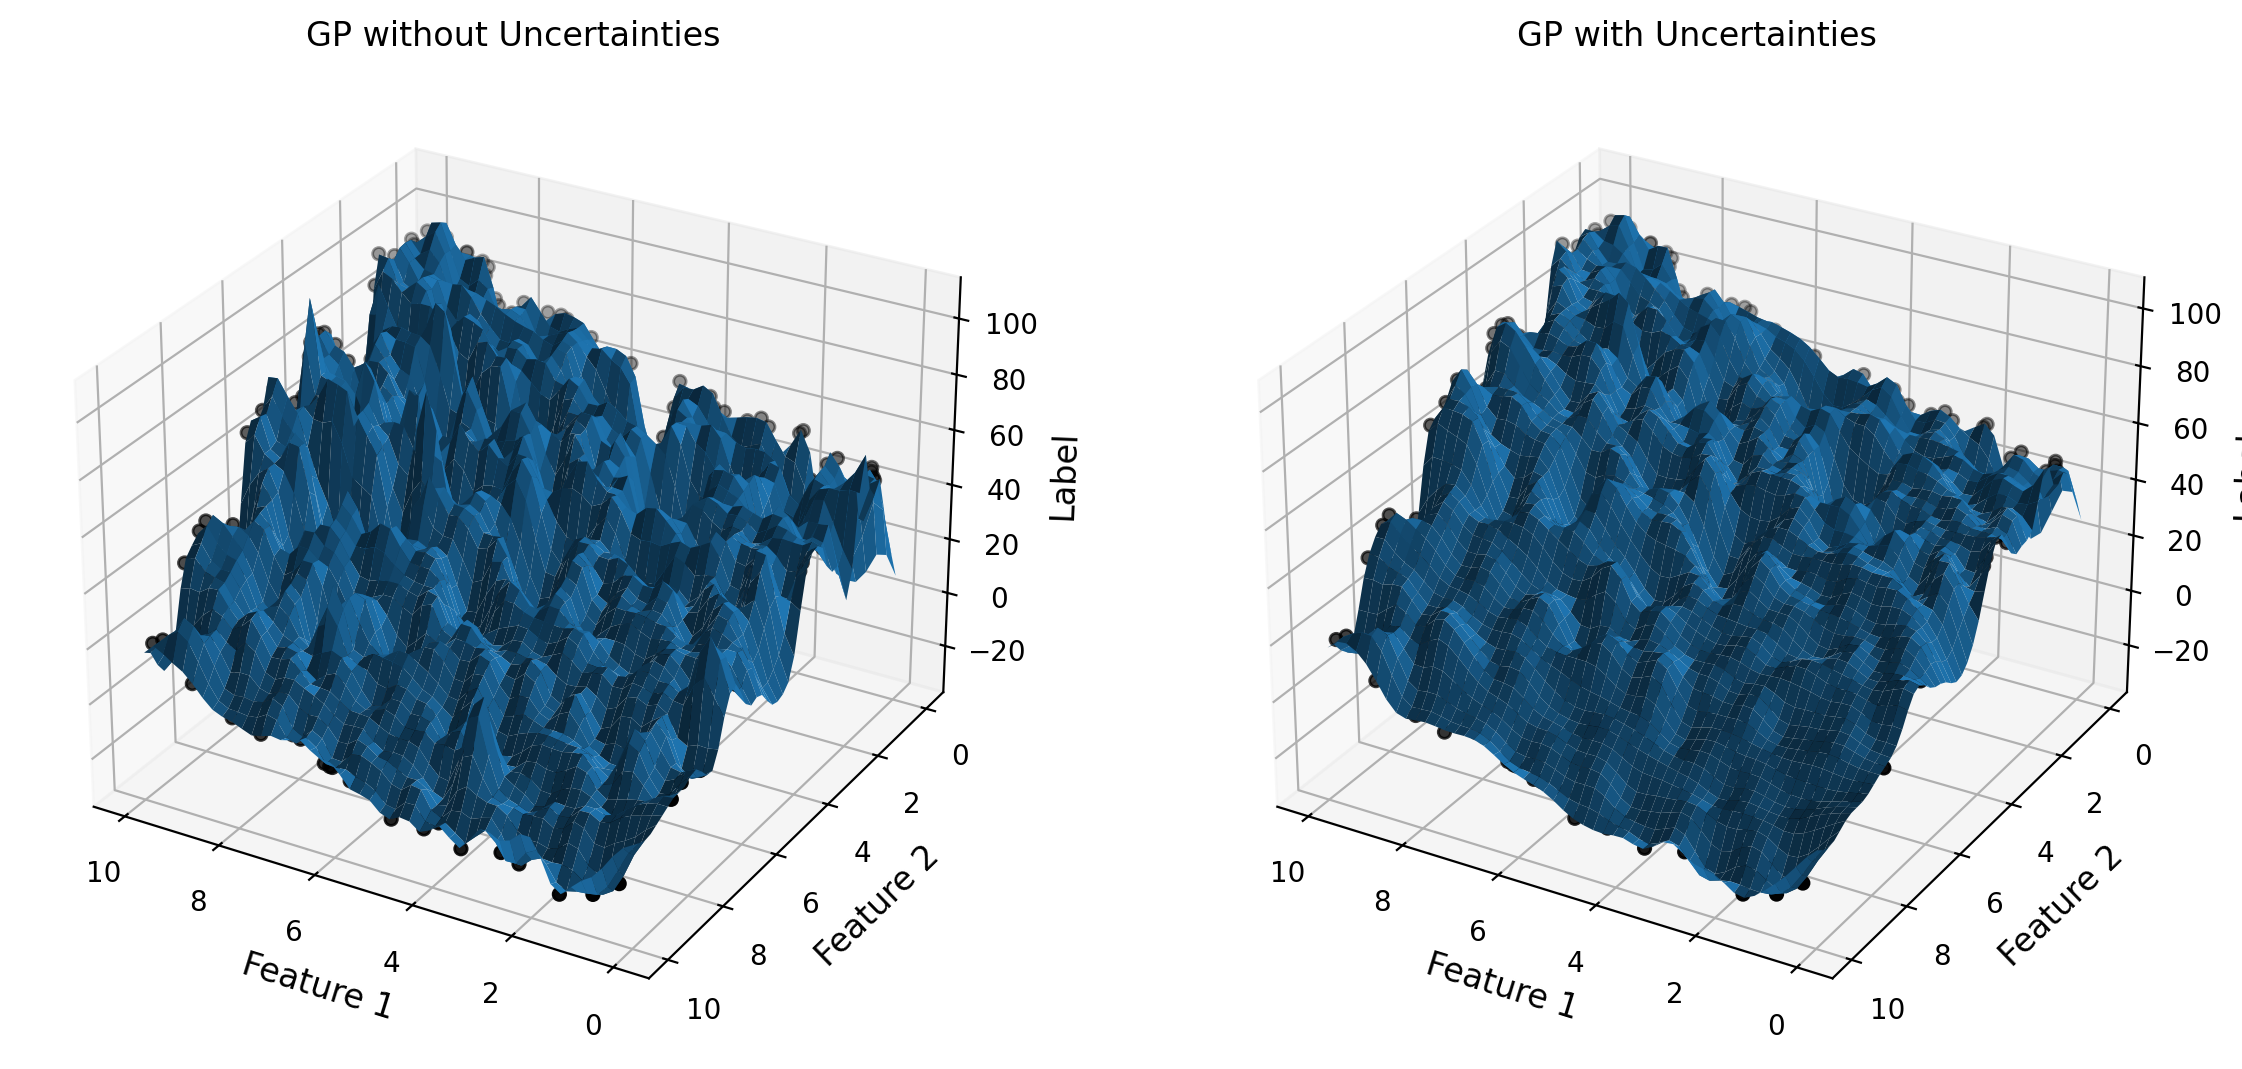

In [239]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a figure for 3D plots
fig = plt.figure(figsize=(14, 7))

# Plot without uncertainties
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X1, X2, Y, color='k', zorder=15,  marker='o', label='Actual Data')
ax1.plot_surface(X1_grid, X2_grid, Y_grid_pred, edgecolor='none')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_zlabel('Label', fontsize=12)
ax1.set_title('GP without Uncertainties')
ax1.view_init(elev=28, azim=120)

# Plot with uncertainties
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X1, X2, Y, color='k', zorder=15, marker='o', label='Actual Data')
ax2.plot_surface(X1_grid, X2_grid, Y_grid_pred_uncertainty, edgecolor='none')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_zlabel('Label', fontsize=12)
ax2.set_title('GP with Uncertainties')
ax2.view_init(elev=28, azim=120)

plt.show()


SRT: Cool visualization!

## Problem 6

6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


In [240]:
from astroML.linear_model import PolynomialRegression

# FitPoly  model
degree = 4
model = PolynomialRegression(degree)
model.fit(X, Y, yerr)

print("Intercept:", model.coef_[0])
print("Coefficients", model.coef_[1:])

Intercept: 49.988758164801816
Coefficients [ 0.5543134  -0.20786648  0.28653691  0.00293842 -0.78223011  0.02476033
  0.02457483 -0.02222336  0.00968418 -0.00099596 -0.00112284 -0.00114462
  0.00210142 -0.00108539]


In [248]:
#Predict values 
X1_grid = np.linspace(X1.min(), X1.max(), 50)
X2_grid = np.linspace(X2.min(), X2.max(), 50)


X1_mean = np.mean(X1)
X2_mean = np.mean(X2)
X_pred1 = np.vstack((X1_grid, np.full_like(X1_grid, X2_mean))).T 
X_pred2 = np.vstack((np.full_like(X2_grid, X1_mean), X2_grid)).T 

# Predcitions
y_pred1 = model.predict(X_pred1)
y_pred2 = model.predict(X_pred2)

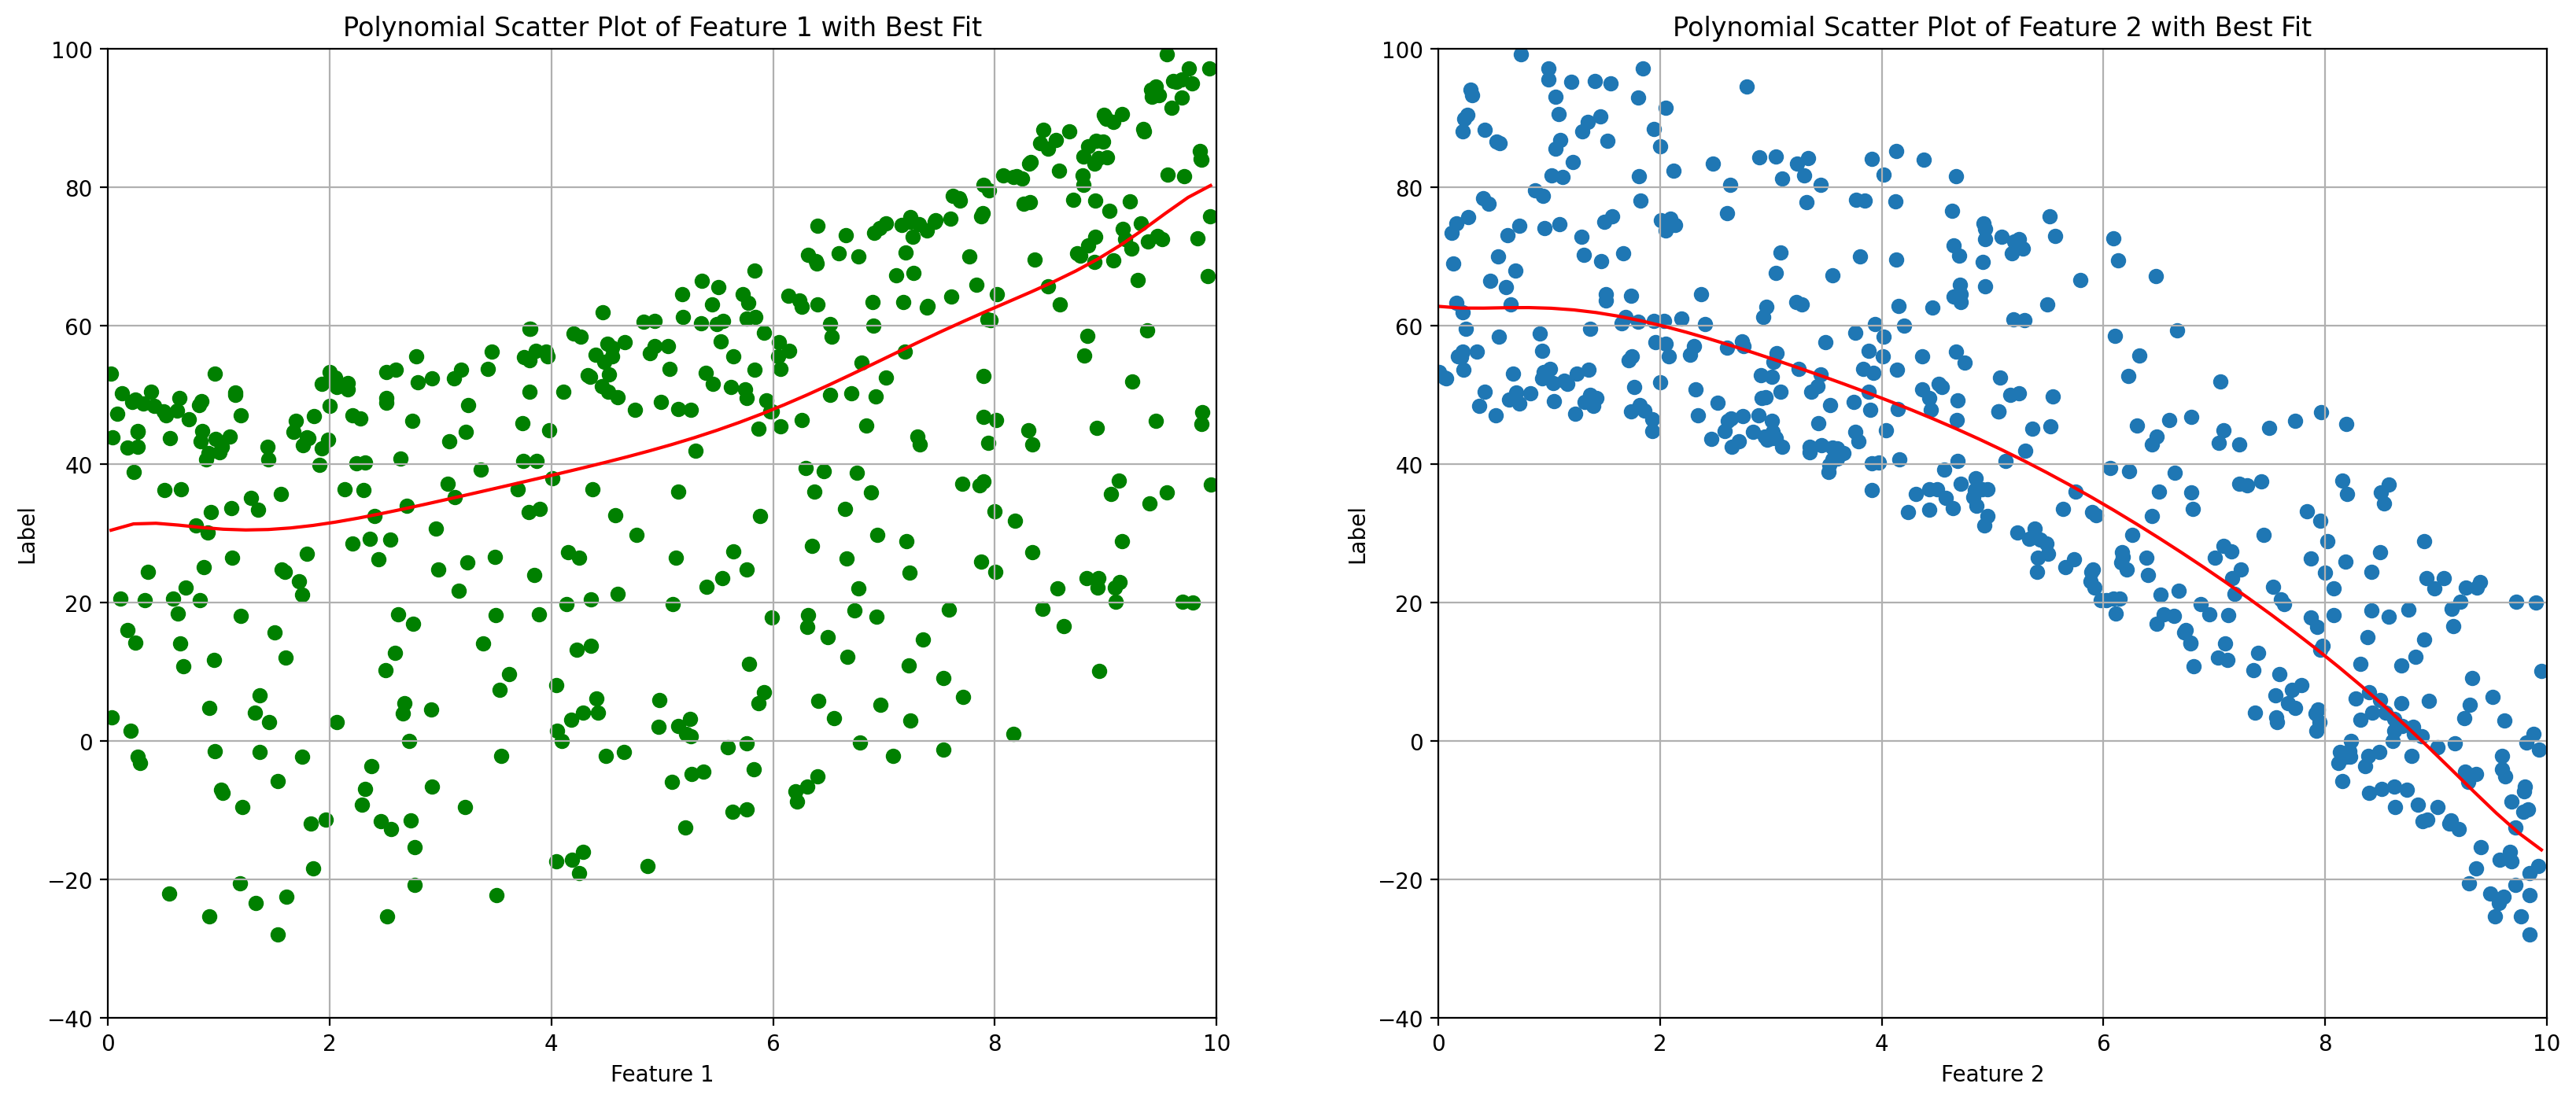

In [249]:
plt.figure(figsize=(20, 8))

# Plot for Feature 1
plt.subplot(1, 2, 1)
plt.scatter(X1, Y, color='green') # data
plt.plot(X1_grid, y_pred1, color='red') #best fit line
plt.title('Polynomial Scatter Plot of Feature 1 with Best Fit')
plt.xlabel('Feature 1')
plt.ylabel('Label')
plt.xlim(0,10)
plt.ylim(-40,100)
plt.grid(True)

# Plot for Feature 2
plt.subplot(1, 2, 2)
plt.scatter(X2, Y)
plt.plot(X2_grid, y_pred2, color='red')  
plt.title('Polynomial Scatter Plot of Feature 2 with Best Fit')
plt.xlabel('Feature 2')
plt.ylabel('Label')
plt.xlim(0,10)
plt.ylim(-40,100)
plt.grid(True)

plt.show()

#### Response to problem 6: The best fit line on the data for the Polynomial Regression looks a bit better compared to the linear regression. Doing a polynomial fit allows for the line to follow the curvature and non linear behavior of the data which also shifts upwards or downwards depending on the features as some some areas have a larger clustering of the data. Also, the line looks good visually by inspection when also using degree of 2,3,5 and 6 before it begins to overfit, and of course excluding degree of 1, as this is a linear fit 

## Problem 7

7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

In [243]:
from sklearn.model_selection import train_test_split

#Split the training and test data 
X_train, X_test, Y_train, Y_test, yerr_train, yerr_test = train_test_split(X, Y, yerr, test_size=0.2, random_state=0)
X_train_final, X_val, Y_train_final, Y_val, yerr_train_final, yerr_val = train_test_split(X_train, Y_train, yerr_train, test_size=0.2, random_state=0)


In [244]:
# #Compute training and CV RMS
from sklearn.metrics import mean_squared_error

rms_train_err = []
rms_validate_err = []
BIC_values = []

n_train = len(Y_train_final) 
n_val = len(Y_val)

for degree in range(1, 11):
    model = PolynomialRegression(degree)
    model.fit(X_train_final, Y_train_final, yerr_train_final)
    
    # Predict fro  training set
    Y_pred_train = model.predict(X_train_final)
    Y_pred_val = model.predict(X_val)
    
    # Find RMS
    rms_train = np.sqrt(mean_squared_error(Y_train_final, Y_pred_train))
    rms_validate = np.sqrt(mean_squared_error(Y_val, Y_pred_val))
    
    rms_train_err.append(rms_train)
    rms_validate_err.append(rms_validate)
    k = degree + 1  
    
    # Adjusted BIC based on RMS error directly, as shown in the class example
    BIC_train = np.sqrt(n_train) * rms_train / yerr_train_final.mean() + k * np.log(n_train)
    BIC_validate = np.sqrt(n_val) * rms_validate / yerr_val.mean() + k * np.log(n_val)
    
    # Here, choosing to keep track of validation BIC; adjust as needed
    BIC_values.append(BIC_validate)


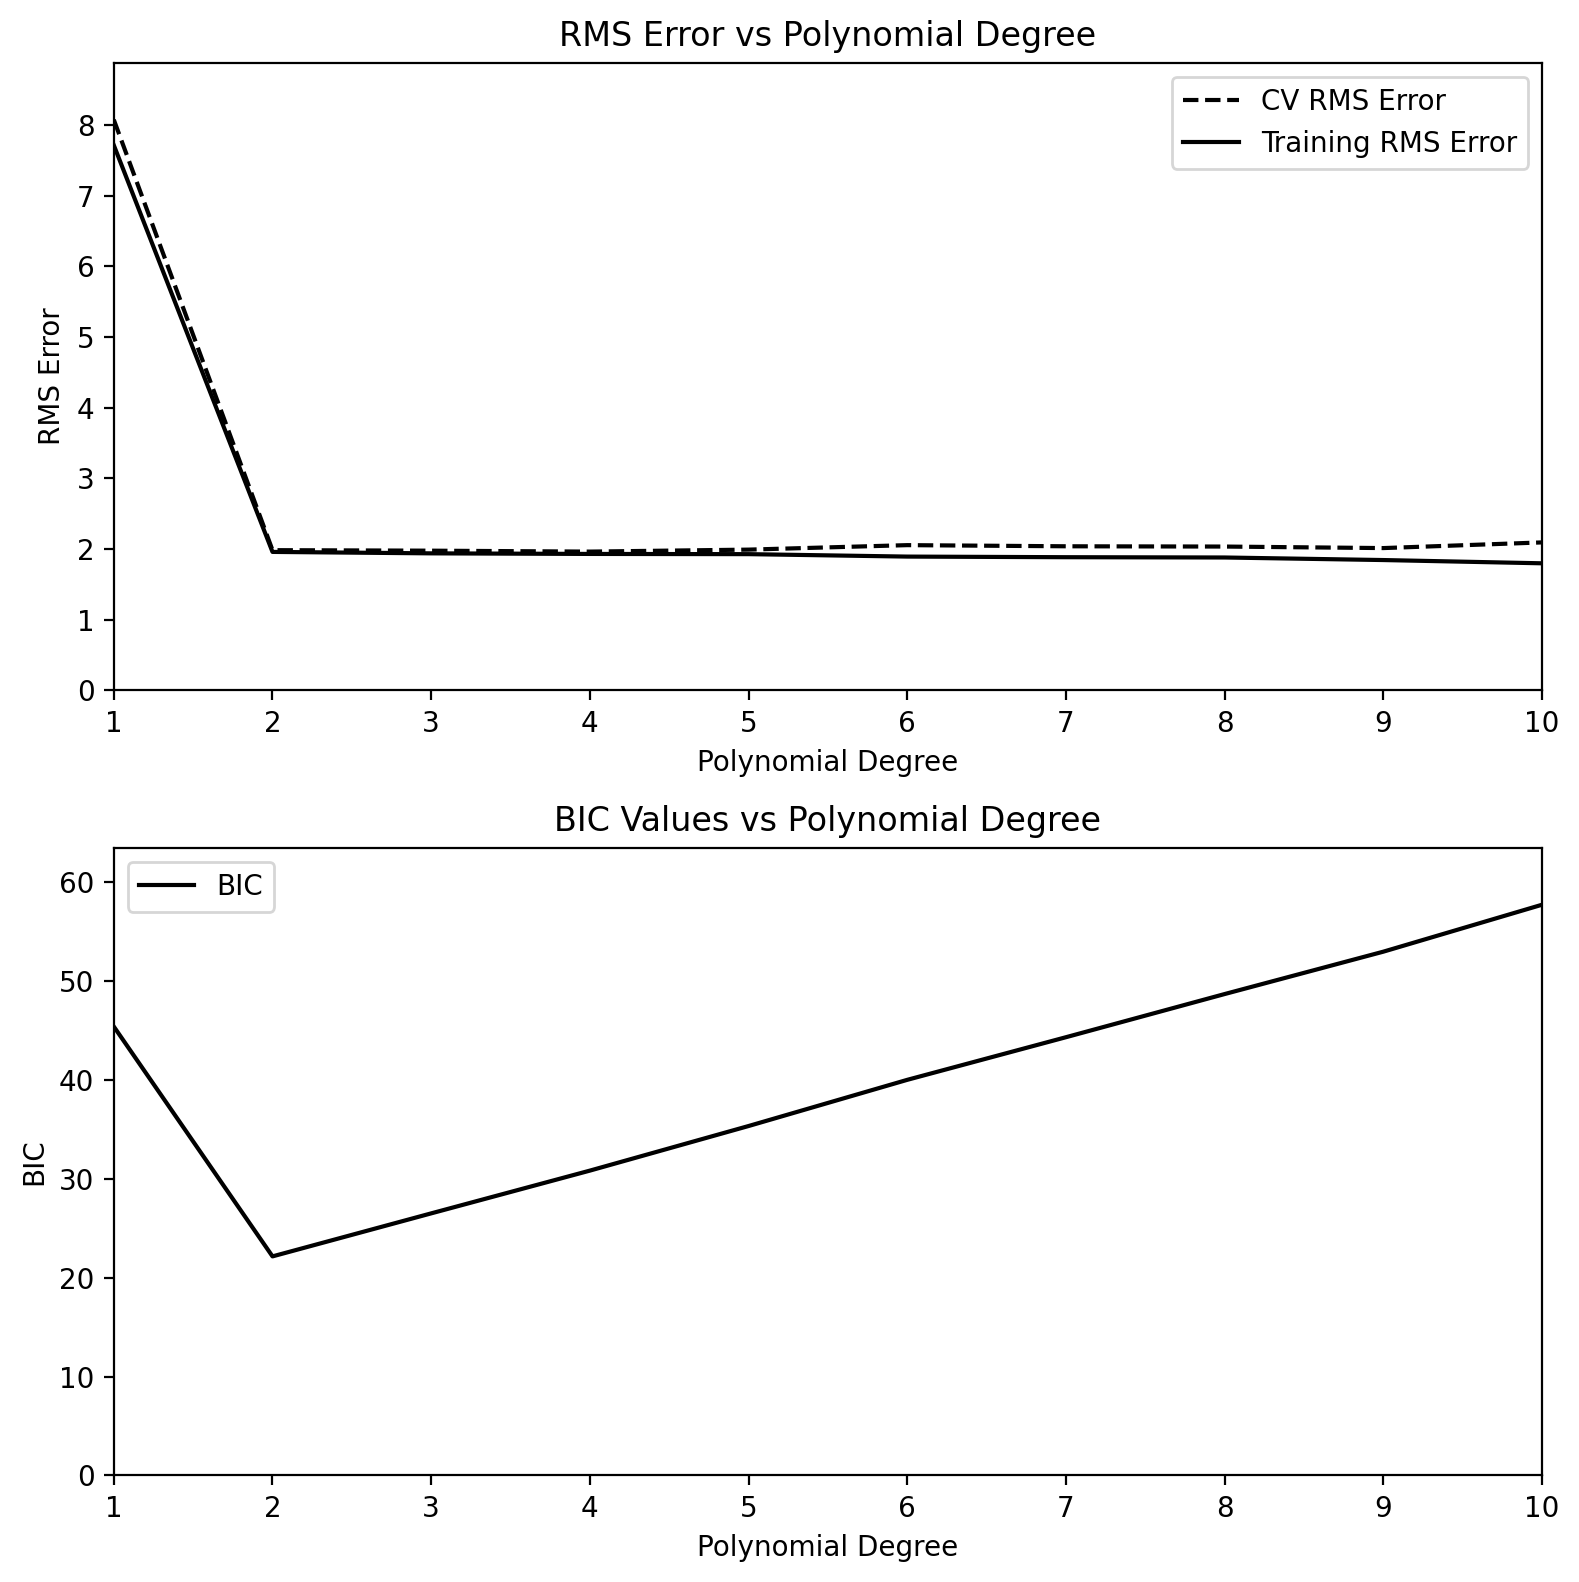

In [245]:
import matplotlib.pyplot as plt
import numpy as np

degrees = np.arange(1, 11) 
fig = plt.figure(figsize=(8, 8))

# Plotting RMS errors
ax1 = fig.add_subplot(211)
ax1.plot(degrees, rms_validate_err, '--k', label='CV RMS Error')
ax1.plot(degrees, rms_train_err, '-k', label='Training RMS Error')
ax1.set_xlim(1, 10)
ax1.set_ylim(0, np.max(rms_validate_err) * 1.1)  # Adjusting ylim based on max validation error
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('RMS Error')
ax1.legend()
ax1.set_title('RMS Error vs Polynomial Degree')

# Plotting BIC values
ax2 = fig.add_subplot(212)
ax2.plot(degrees, BIC_values, '-k', label='BIC')
ax2.set_xlim(1, 10)
ax2.set_ylim(0, np.max(BIC_values) * 1.1)  # Adjusting ylim based on max BIC value
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('BIC')
ax2.legend()
ax2.set_title('BIC Values vs Polynomial Degree')

plt.tight_layout()
plt.show()


SRT: Very well done, Shaniya.

In [246]:
#Retrain model on best degree
Good_Degree = 2

# Redo model 
Top_model = PolynomialRegression(Good_Degree)
Top_model.fit(X_train, Y_train, yerr_train) 

# Predict
Y_pred_test = Top_model.predict(X_test)

# Find error
New_RMSerror = np.sqrt(mean_squared_error(Y_test, Y_pred_test))

print("Labels", Y_pred_test)
print("Error from Top Degree", New_RMSerror)

Labels [ 21.92328264  -5.27915793  94.42634102  54.73238725  56.90620997
  41.70473575  86.2435694   70.17323832  50.62137039  46.63045566
  90.47817426  15.20006998  59.33127225  73.17963385  -1.60360629
  49.7346563   23.85262456  34.23300462  95.1681445   -5.23588215
  33.24130643  50.25802016  96.50104344  72.62452789  43.05833293
   5.29179866  37.1167164   17.67506709  72.40690622  49.63455362
  28.32607603  80.98802782  51.36551089   3.00682671  44.82101434
   6.57613372  47.61616725  62.27145912  85.57760628 -17.04081032
  55.77794409  53.77764804  40.24740307   8.68040263  -5.96596996
  50.03607978  65.3074602    1.61531398  61.52192272  36.98651065
  11.09904379  73.61367028  -7.08706398  49.5538884   10.61559121
  44.41942158  55.56493542   2.64720597  95.0056541  -26.02424772
  94.08214298  42.89771297 -22.46287958  23.74956008  66.7632331
  37.40979808  49.35932606  83.91540556  70.49669763  48.89486015
   4.98788769  38.03340735  48.74389542  93.34422304  69.93255913
  44